Notebook dedicado a subir los modelos con mejores resultados

In [1]:
# --------------------------------------------------------------
# System utilities
# --------------------------------------------------------------
import os
import joblib

# --------------------------------------------------------------
# Data manipulation libraries
# --------------------------------------------------------------
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Support for large, multi-dimensional arrays and matrices

# --------------------------------------------------------------
# Data visualization libraries
# --------------------------------------------------------------
import matplotlib.pyplot as plt  # 2D plotting library
import seaborn as sns            # Statistical data visualization built on top of Matplotlib
import plotly.express as px      # Interactive visualizations for data exploration
import plotly.graph_objects as go  # Low-level interface for creating more complex Plotly visualizations

# --------------------------------------------------------------
# Machine learning models and metrics from scikit-learn
# --------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Feature scaling methods
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold  # Model selection and validation
from sklearn.linear_model import LogisticRegression  # Logistic regression model
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.tree import DecisionTreeClassifier      # Decision Tree classifier
from sklearn.metrics import (                        # Model evaluation metrics
    classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, 
    mean_squared_error, mean_absolute_error, r2_score, 
    accuracy_score, precision_score, recall_score, f1_score, 
    make_scorer)

# --------------------------------------------------------------
# Libraries for handling imbalanced datasets
# --------------------------------------------------------------
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique for class imbalance
from imblearn.pipeline import Pipeline    # Pipeline for combining steps in model training and evaluation

# --------------------------------------------------------------
# Advanced visualization utilities for interactive plots
# --------------------------------------------------------------
from plotly.subplots import make_subplots  # Create complex multi-plot visualizations

In [2]:
# Get the current working directory
directorio_actual = os.getcwd()

# Specify the relative path from the current directory
ruta_csv_relativa = os.path.join('..','data','03_primary','3.spotify.csv')

# Load the CSV file
spotify = pd.read_csv(ruta_csv_relativa)

In [3]:
# Predictor sets
predictors_essential = ['danceability_scaled', 'energy_scaled', 'loudness_scaled', 'speechiness_scaled', 'intensity']
predictors_simplified = ['loudness_scaled', 'intensity', 'speechiness_scaled']
predictors_moderate = ['danceability_scaled', 'energy_scaled', 'loudness_scaled', 'speechiness_scaled', 'valence_scaled', 'intensity']
predictors_complete = ['danceability_scaled', 'energy_scaled', 'loudness_scaled', 'speechiness_scaled', 'acousticness_scaled', 'instrumentalness_scaled',
                       'liveness_scaled', 'valence_scaled', 'intensity']

def train_multiple_baseline_models(X, y):
    """

    This function trains multiple classification models with default parameters (baseline models)
    and displays performance metrics for each model, including the ROC curve and AUC.

    Parameters:
    - X: Feature set.
    - y: Target labels.

    Return:
    - results: List of dictionaries containing model performance metrics.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Models to be trained
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
    }

    # Store results for ROC curves
    roc_curves = []

    # Iterate over the models and train each one
    results = []
    for model_name, model in models.items():
        print(f"\nTraining and evaluation: {model_name}")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Predict probabilities for ROC curve (if the model supports it)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1] # Probability of the positive class
        else:
            y_prob = None # For models without predict_proba (e.g, SVM with Linear kernel)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        confusion_mtx = confusion_matrix(y_test, y_pred)

        # Calculate ROC curve and AUC if probabilities are available
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)

            # Store the ROC curve results
            roc_curves.append((fpr, tpr, model_name, auc))

        else:
            auc = 'N/A'

        # Save the results
        results.append({
            'model': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': confusion_mtx,
            'AUC': auc
        })

        # Display the metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc}")
        print("Confusion Matrix:")
        print(confusion_mtx)

    # Plot all ROC curves at the end
    plt.figure()
    for fpr, tpr, model_name, auc in roc_curves:
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

    return results

In [4]:
def optimize_simple_model(model, param_grid, X, y, test_size, scoring):
    """
    This function optimizes a model's hyperparameters using GridSearchCV and returns the best model with its metrics.

    Parameters:
    - model: The model to be trained (e.g., RandomForestClassifier()).
    - param_grid: A dictionary of hyperparameters for GridSearchCV.
    - X: Feature set.
    - y: Target labels (dependent variable).
    - test_size: Proportion of data for the test set (default is 0.2).
    - scoring: Metric to optimize (default is 'accuracy').

    Returns:
    - best_model: The model with the best hyperparameters.
    - metrics: A dictionary containing performance metrics (accuracy, precision, recall, f1 score).
    """

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Create GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1)

    # Train the model with the training data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Create a dictionary with the metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    # Display results
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])

    return best_model, metrics

In [5]:
# Example usage:
# Parameters to optimize for RandomForest
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Assume you already have your features (X) and target variable (y)
X = spotify[predictors_complete]  # Your features -- predictors_complete
y = spotify['popularity_class']   # Your target variable

# Call the function to optimize the model
best_model_rf, metrics_rf = optimize_simple_model(
    RandomForestClassifier(random_state=50),
    param_grid_rf,
    X,
    y,
    test_size=0.2,
    scoring='accuracy'
)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.7659
Precision: 0.7664
Recall: 0.7659
F1 Score: 0.7660
Confusion Matrix:
[[9095 2835]
 [2494 8336]]


### Modelo 1

In [6]:
# Example usage:
# Parameters to optimize for RandomForest
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Assume you already have your features (X) and target variable (y)
X = spotify[predictors_complete]  # Your features -- predictors_complete
y = spotify['popularity_class']   # Your target variable

# Call the function to optimize the model
best_model_rf, metrics_rf = optimize_simple_model(
    RandomForestClassifier(random_state=50),
    param_grid_rf,
    X,
    y,
    test_size=0.2,
    scoring='accuracy'
)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.7659
Precision: 0.7664
Recall: 0.7659
F1 Score: 0.7660
Confusion Matrix:
[[9095 2835]
 [2494 8336]]


### Modelo 2

In [7]:
# Define features (predictors_complete) and the target (popularity_class)
X = spotify[predictors_complete]  # Your features
y = spotify['popularity_class']   # Your target variable

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model (RandomForestClassifier)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Define the path to save the model
model_path = '../data/06_models/simple_random_forest_model.pkl'

# Save the trained model
joblib.dump(rf, model_path)
print(f"Model saved as {model_path}")

Model saved as ../data/06_models/simple_random_forest_model.pkl


Model loaded successfully
Accuracy: 0.7634
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     11930
           1       0.74      0.76      0.75     10830

    accuracy                           0.76     22760
   macro avg       0.76      0.76      0.76     22760
weighted avg       0.76      0.76      0.76     22760

Confusion Matrix:
[[9093 2837]
 [2547 8283]]
ROC-AUC: 0.8656


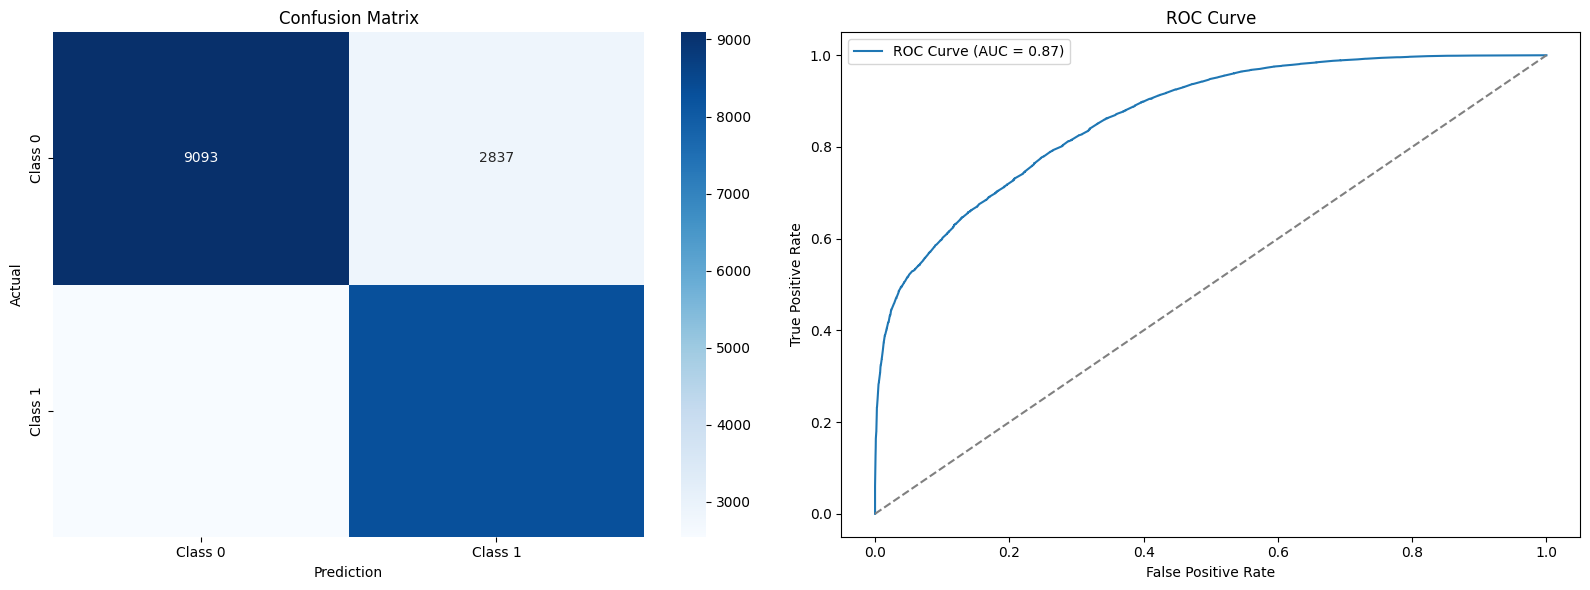

In [8]:
# Load the saved model
rf = joblib.load('../data/06_models/simple_random_forest_model.pkl')
print("Model loaded successfully")

# Make predictions on the test set
y_pred = rf.predict(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# 4. ROC-AUC (For binary classification)
if len(set(y_test)) == 2:
    y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probability of the positive class
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Get ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Create subplots to show the confusion matrix and ROC curve together
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Subplot 1: Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=ax[0])
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Actual')
    ax[0].set_title('Confusion Matrix')

    # Subplot 2: ROC Curve
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc='best')

    # Show both plots
    plt.tight_layout()
    plt.show()

### Modelo 3


Training and evaluation: Logistic Regression
Accuracy: 0.5789
Precision: 0.5776
Recall: 0.5789
F1 Score: 0.5740
AUC: 0.6015667107062668
Confusion Matrix:
[[8106 3824]
 [5761 5069]]

Training and evaluation: Random Forest
Accuracy: 0.7438
Precision: 0.7442
Recall: 0.7438
F1 Score: 0.7439
AUC: 0.8452669504086241
Confusion Matrix:
[[8871 3059]
 [2773 8057]]

Training and evaluation: Decision Tree
Accuracy: 0.7071
Precision: 0.7073
Recall: 0.7071
F1 Score: 0.7072
AUC: 0.7049208061181763
Confusion Matrix:
[[8523 3407]
 [3259 7571]]


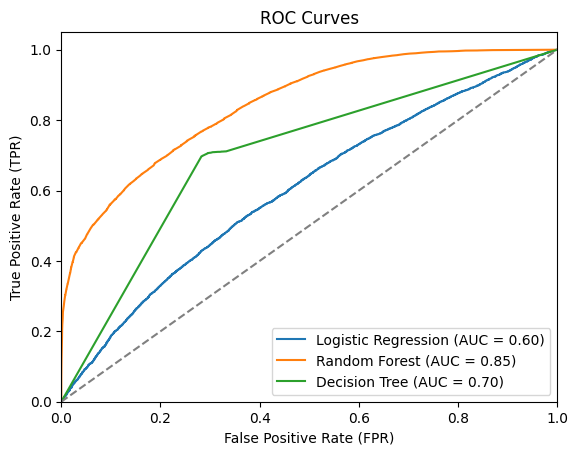

In [9]:
X = spotify[predictors_moderate] 
y = spotify['popularity_class']  

results = train_multiple_baseline_models(X, y)

### Modelo 4


Training and evaluation: Logistic Regression
Accuracy: 0.5569
Precision: 0.5547
Recall: 0.5569
F1 Score: 0.5515
AUC: 0.5805799140724711
Confusion Matrix:
[[7884 4046]
 [6040 4790]]

Training and evaluation: Random Forest
Accuracy: 0.7287
Precision: 0.7296
Recall: 0.7287
F1 Score: 0.7289
AUC: 0.8314774202236965
Confusion Matrix:
[[8614 3316]
 [2858 7972]]

Training and evaluation: Decision Tree
Accuracy: 0.6993
Precision: 0.6999
Recall: 0.6993
F1 Score: 0.6995
AUC: 0.6973452828480077
Confusion Matrix:
[[8360 3570]
 [3273 7557]]


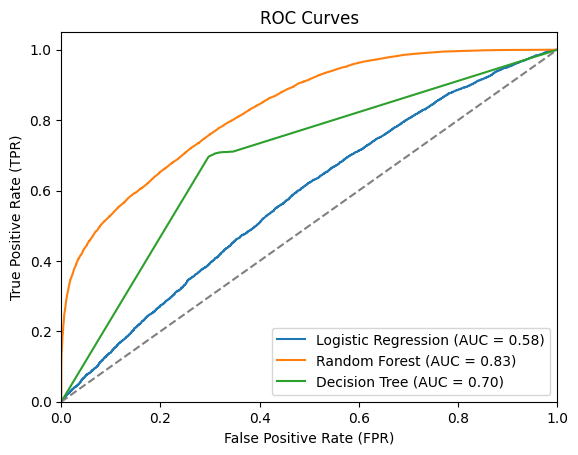

In [10]:
# Example usage
# X and y are your data (X: features, y: labels)
X = spotify[predictors_essential]  # Your features
y = spotify['popularity_class']    # Your label or target variable

results = train_multiple_baseline_models(X, y)

### Modelo 5

In [ ]:
def evaluate_stratified_model(model, X, y, cv_folds, metrics=['accuracy', 'precision', 'recall', 'roc_auc']):
    """
    Function that takes a model, features (X), target (y), and evaluates it using stratified cross-validation.
    
    Parameters:
    - model: The machine learning model.
    - X: Input features.
    - y: Target or dependent variable.
    - metrics: List of metrics to evaluate (default: 'accuracy', 'precision', 'recall', 'roc_auc').
    - cv_folds: Number of folds for cross-validation (default: 5).
    
    Returns:
    - Stratified cross-validation results: Averages of metrics and timing information.
    """
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define stratified cross-validation
    strat_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Apply stratified cross-validation
    cv_results = cross_validate(model, X_scaled, y, cv=strat_kfold, scoring=metrics, return_train_score=True)

    # Display the results of the metrics and timing
    print("Stratified cross-validation results:")
    
    for metric in metrics:
        print(f"Mean {metric.capitalize()}: {cv_results[f'test_{metric}'].mean():.4f}")
    
    print(f"Mean Training Time: {cv_results['fit_time'].mean():.4f} seconds")
    print(f"Mean Prediction Time: {cv_results['score_time'].mean():.4f} seconds")
    
    return cv_results

In [11]:
# Example usage with a pre-defined model
# Define features and target
X = spotify[predictors_complete]
y = spotify['popularity_class']

# Load or use the model already trained or configured
rf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_folds = 5  # 5 - 10
# Call the function to evaluate the model using stratified cross-validation
stratified_results = evaluate_stratified_model(rf, X, y, cv_folds)

NameError: name 'evaluate_stratified_model' is not defined